## Diagnosis System

pre-trained model on a variety of de-identified medical data, including chest X-rays, dermatology images, ophthalmology images, and histopathology slides.

Tasks: different multimodal classification, report generation, visual question answering, and text-based tasks.

In [ ]:
! pip install --upgrade --quiet accelerate bitsandbytes transformers huggingface_hub

In [2]:
from google.colab import userdata
from huggingface_hub import login

login(token=userdata.get("niru_hf_read"))

In [ ]:
from transformers import AutoModelForImageTextToText, AutoProcessor, BitsAndBytesConfig
from PIL import Image
import requests
import torch

model_id = "google/medgemma-4b-it"

model_kwargs = dict(
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

model_kwargs["quantization_config"] = BitsAndBytesConfig(load_in_4bit=True)

model = AutoModelForImageTextToText.from_pretrained(
    model_id,
    **model_kwargs,
)
processor = AutoProcessor.from_pretrained(model_id)

In [12]:
def medical_VQA(system_instruction, prompt, image):

  messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": system_instruction}]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": prompt},
            {"type": "image", "image": image}
        ]
    }
  ]

  inputs = processor.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
  ).to(model.device, dtype=torch.bfloat16)

  input_len = inputs["input_ids"].shape[-1]

  with torch.inference_mode():
      generation = model.generate(**inputs, max_new_tokens=300, do_sample=False)
      generation = generation[0][input_len:]
      decoded = processor.decode(generation, skip_special_tokens=True)

  return decoded

In [23]:
import os
from IPython.display import Image as IPImage, display, Markdown

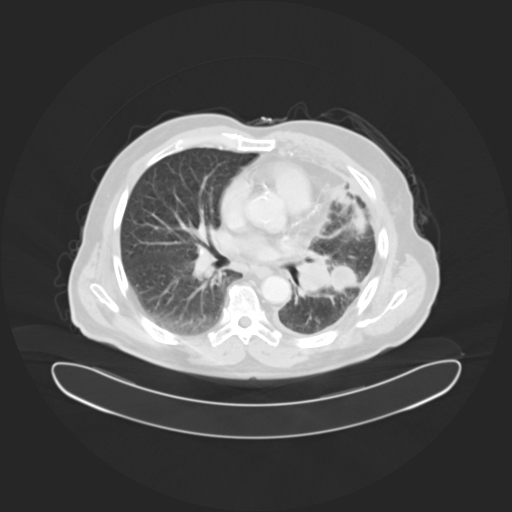

In [21]:
prompt = "What is the type of lung cancer"  # @param {type: "string"}

system_instruction = "You are an expert radiologist." # @param {type: "string"}

image_url = "/content/image_case_2.jpg"  # @param {type: "string"}
use_local_image_url = True  # @param {type: "boolean"}

if use_local_image_url:
  image = Image.open(image_url)
else:
  ! wget -nc -q {image_url}
  image_filename = os.path.basename(image_url)
  image = Image.open(image_filename)

image

In [22]:
response = medical_VQA(system_instruction, prompt, image)

display(Markdown(f"\n\n---\n\n**[ MedGemma Response ]**\n\n{response}\n\n---\n\n"))

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.




---

**[ MedGemma Response ]**

Based on the image provided, the lung cancer appears to be a **left upper lobe mass with a cavitary component**.

Here's a breakdown of why:

*   **Location:** The mass is located in the left upper lobe of the lung.
*   **Cavitary Component:** The presence of a cavity within the mass is a key feature. Cavities are air-filled spaces that can develop within a tumor, often due to necrosis (tissue death) within the tumor.
*   **Appearance:** The mass has a somewhat irregular, heterogeneous appearance, which is typical of a malignant tumor.

**Important Considerations:**

*   **Further Imaging:** This is a single slice of a CT scan. To make a definitive diagnosis, a full series of CT images (including coronal and sagittal views) is needed.
*   **Clinical History:** The patient's clinical history (age, smoking history, symptoms, etc.) is crucial for diagnosis and treatment planning.
*   **Biopsy:** A biopsy is usually required to confirm the diagnosis and determine the specific type of lung cancer.

**In summary, the image shows a left upper lobe lung mass with a cavitary component, which is suggestive of lung cancer. However, a definitive diagnosis requires further imaging and potentially a biopsy.**

**Disclaimer:** This interpretation is based solely on the provided image and is for informational purposes only. It should not be considered a substitute for a professional medical diagnosis.


---



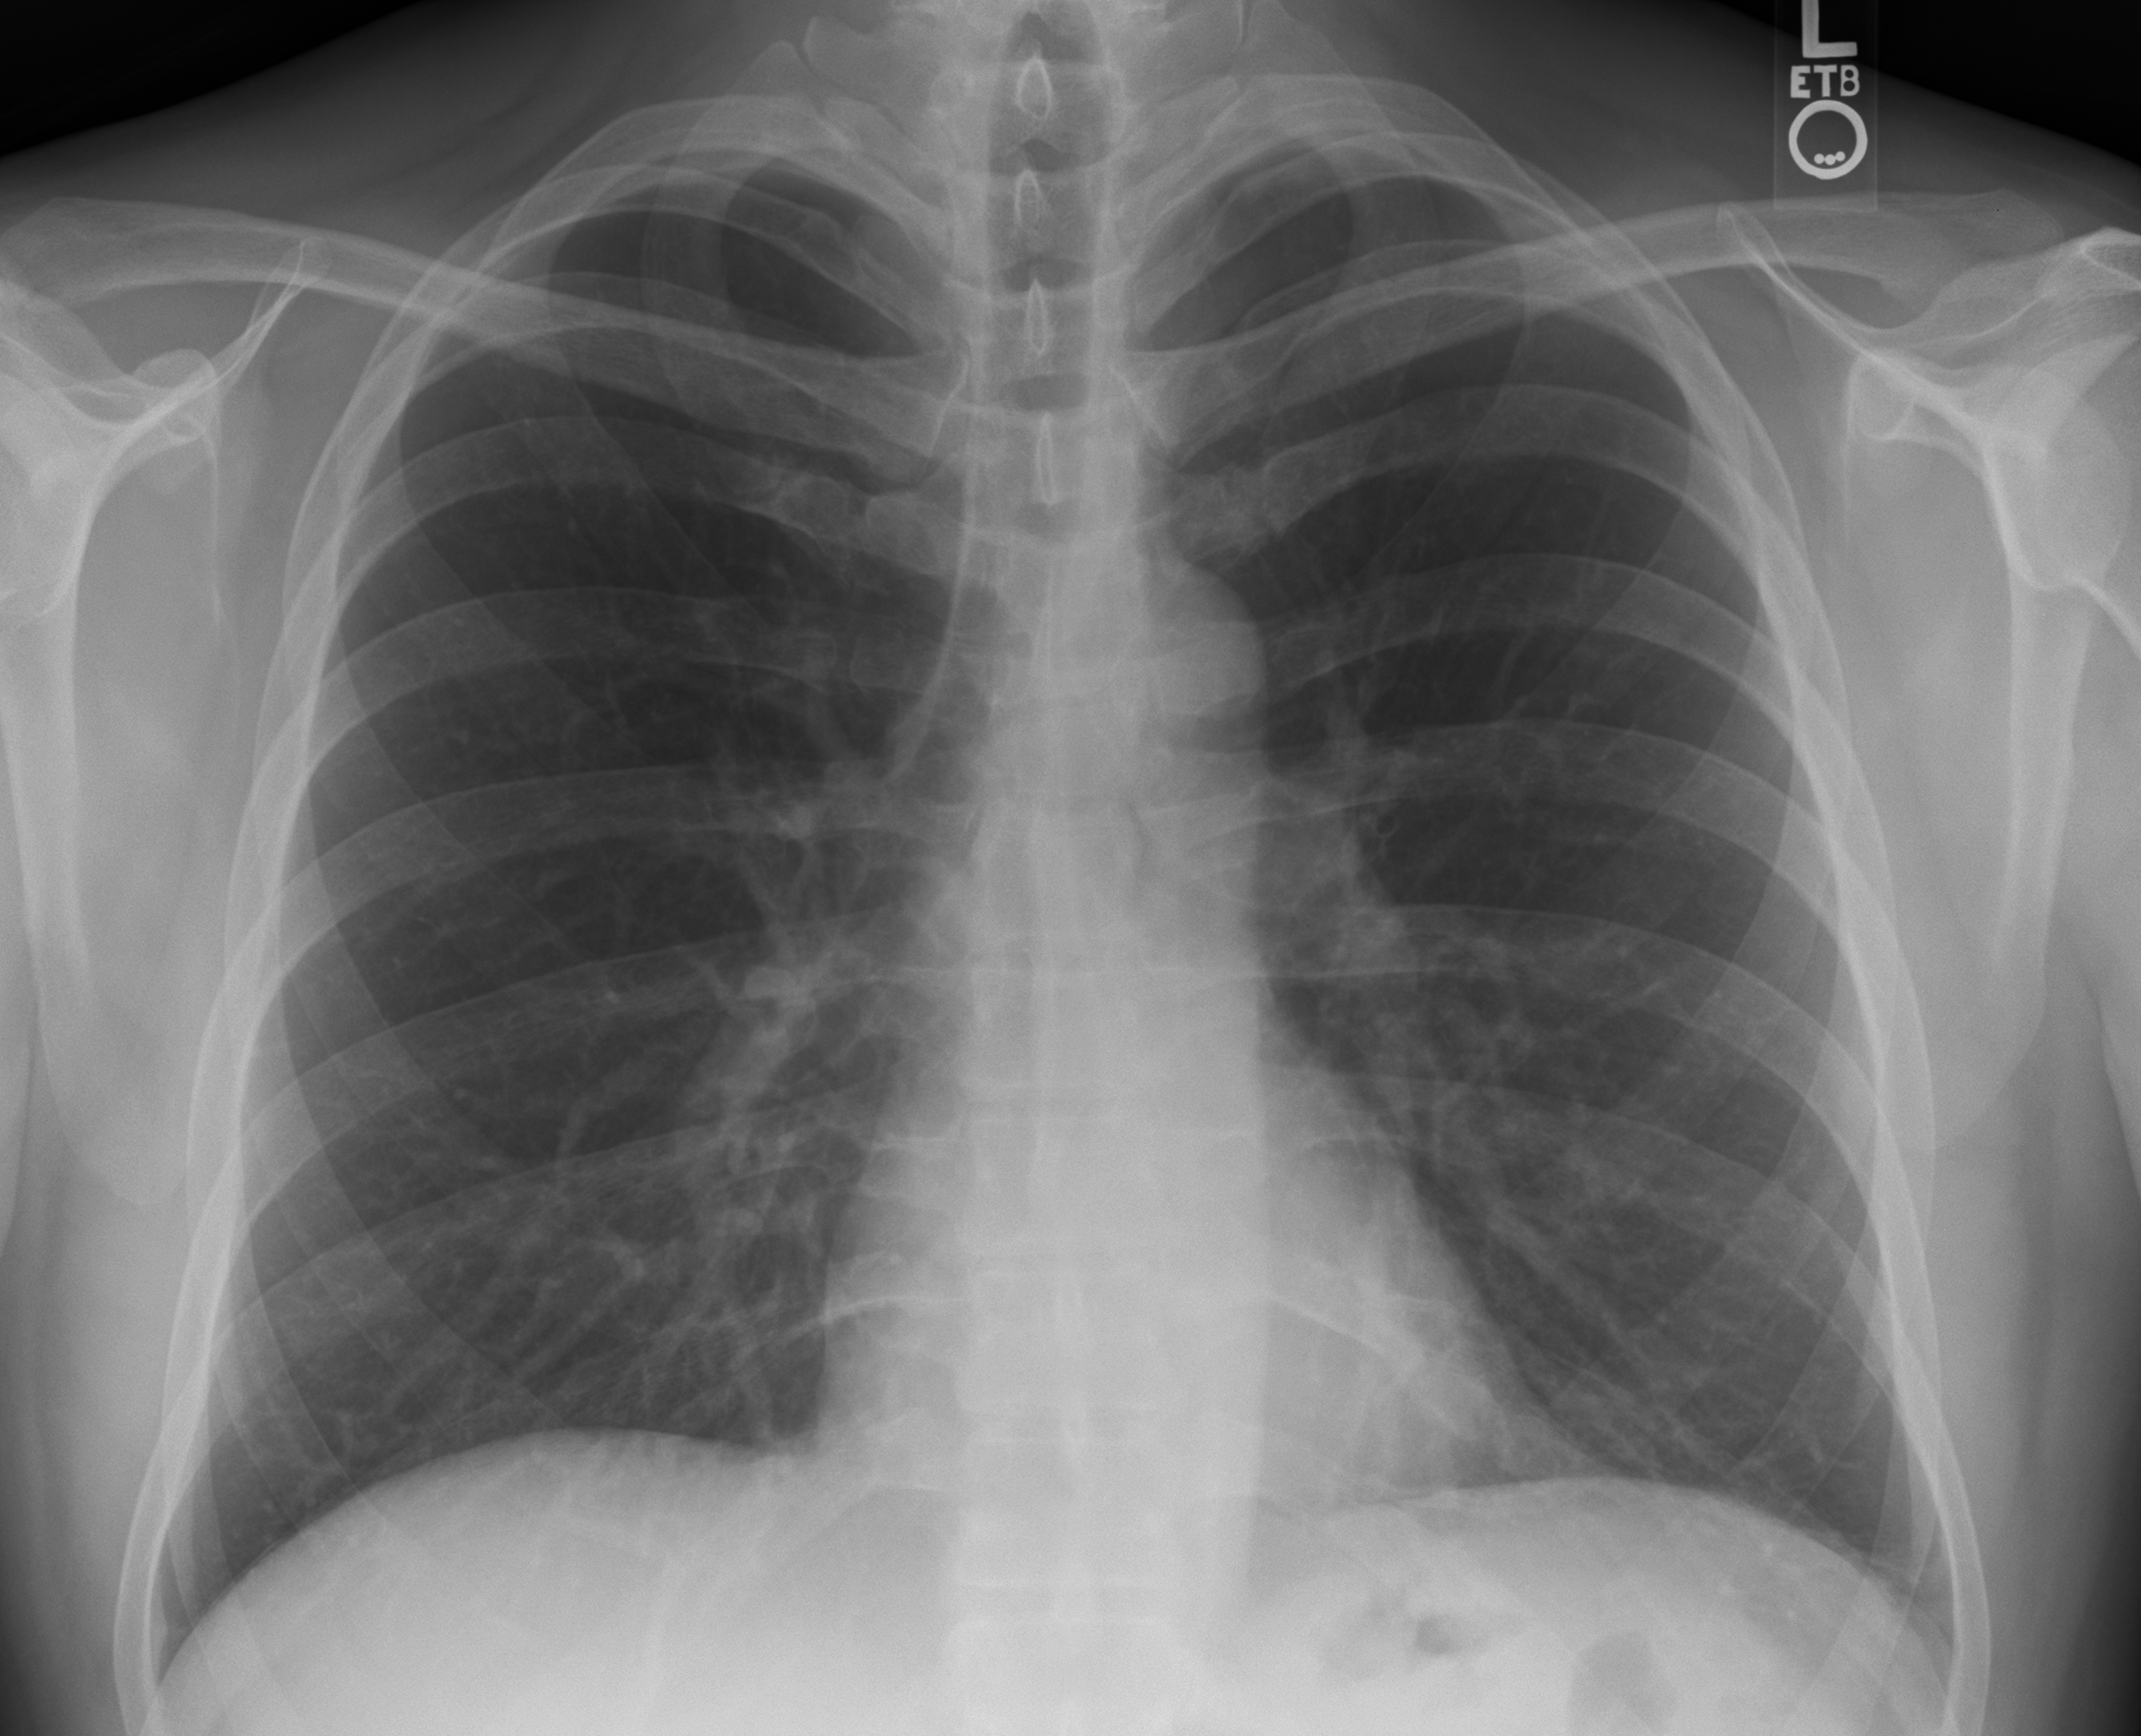

In [24]:
prompt = "Describe this X-ray"  # @param {type: "string"}

system_instruction = "You are an expert radiologist." # @param {type: "string"}

image_url = "https://upload.wikimedia.org/wikipedia/commons/c/c8/Chest_Xray_PA_3-8-2010.png"  # @param {type: "string"}
use_local_image_url = False  # @param {type: "boolean"}

if use_local_image_url:
  image = Image.open(image_url)
else:
  ! wget -nc -q {image_url}
  image_filename = os.path.basename(image_url)
  image = Image.open(image_filename)

image

In [25]:
response = medical_VQA(system_instruction, prompt, image)

display(Markdown(f"\n\n---\n\n**[ MedGemma Response ]**\n\n{response}\n\n---\n\n"))

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.




---

**[ MedGemma Response ]**

Okay, I've reviewed the provided chest X-ray. Here's a description of what I see:

**Overall Impression:**

The X-ray shows a normal adult chest. The lungs appear clear, with no obvious signs of consolidation, effusion, or pneumothorax. The heart size and mediastinal contours are within normal limits.

**Specific Findings:**

*   **Lung Fields:** The lung fields are clear, with no evidence of consolidation, effusion, or pneumothorax.
*   **Heart Size:** The heart size appears normal.
*   **Mediastinum:** The mediastinum is unremarkable.
*   **Ribs:** The ribs appear intact.
*   **Clavicles:** The clavicles appear intact.
*   **Soft Tissues:** The soft tissues of the chest wall are unremarkable.

**In summary, the X-ray is normal.**

**Important Considerations:**

*   This is a single view. A full chest X-ray would include both PA (posterior-anterior) and lateral views for a more comprehensive assessment.
*   The patient's clinical history is crucial for interpreting the X-ray.
*   This interpretation is based solely on the provided image.

**Disclaimer:** This is a preliminary interpretation based on a single image. A definitive diagnosis requires a complete clinical evaluation and potentially additional imaging studies.


---

